In [115]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm,gamma

In [336]:
# The true mean and precision
mean = 4
precision = 8

# Number of simulations
N = 1000

# Hyper parameters
mu_0 = 0
lambda_0 = 0.5
a_0 = 1
b_0 = 1

# Tolerance
TOL = 1e-3  

# Generate data from gaussian with true mean and precision
np.random.seed(0)
X = np.random.normal(loc=mean, scale=np.sqrt(1/precision), size=N)

In [337]:
# Create interpolation grid for the contour plots
mus = np.linspace(mean-1, mean+1, 400)
taus = np.linspace(precision-5, precision+1, 400)

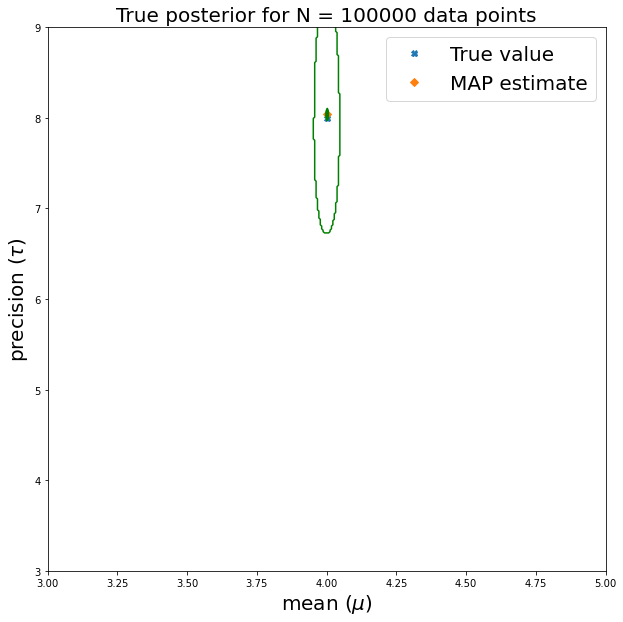

In [348]:
# Contour plots for exact posterior

# Parameters for the posterior distribution
mu_p = (N*X.mean() + mu_0*lambda_0) / (N+lambda_0)
lambda_p = N+lambda_0
alpha_p = N/2 + a_0
beta_p = b_0 + 0.5*(N*np.square(X).mean() + lambda_0*mu_0**2 - (N+lambda_0)*mu_p**2)

# Now compute the probabilities Z_e from the densities
Z_e = np.empty([len(mus), len(taus)]) 

#  Create P(tau) first since P(mu) depends on tau
P_tau = gamma(a=alpha_p, loc=0, scale=1/beta_p)
#  Create  P_mu for every Tau 
for i_tau, tau in enumerate(taus):
    P_mu = norm(loc=mu_p, scale=1/np.sqrt(lambda_p * tau))
    Z_e[:, i_tau] = P_mu.pdf(mus) * P_tau.pdf(tau)
# Find the maximum
Z_mu_e, Z_tau_e = np.unravel_index(np.argmax(Z_e), Z_e.shape)
Z_mu_e, Z_tau_e = mus[Z_mu_e], taus[Z_tau_e]
 
# Contour plot of the true posterior
plt.figure(figsize=[10,10])
plt.plot(mean, precision, 'X', label='True value')
plt.plot(Z_mu_e, Z_tau_e, 'D', label='MAP estimate')
plt.contour(*np.meshgrid(mus, taus), Z_e.T, levels=5, colors=['green'])
# plt.xlim([3.99, 4.02])
# plt.ylim([7.95, 8.1])
plt.xlabel('mean ($\mu$)', fontsize=20)
plt.ylabel('precision ($\\tau$)', fontsize=20)
plt.title('True posterior for N = {} data points'.format(N),fontsize=20)
_ = plt.legend(fontsize=20)



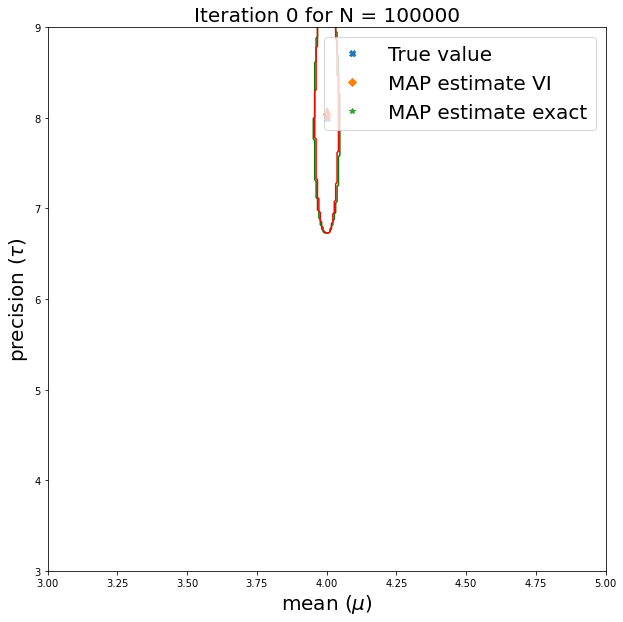

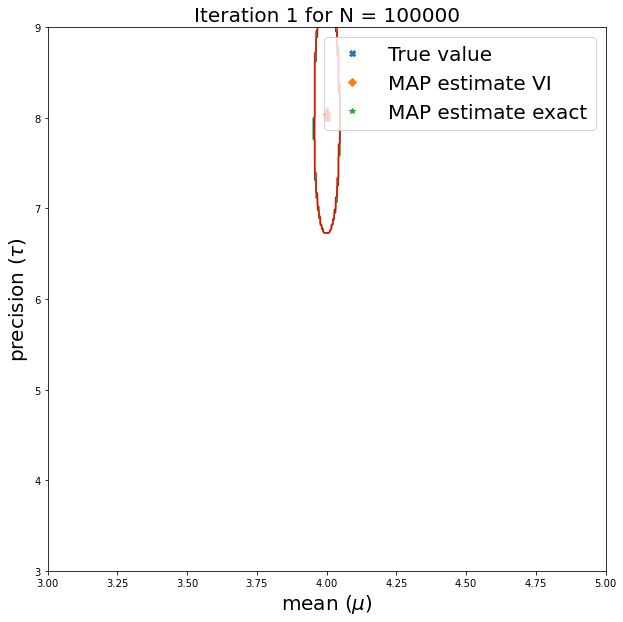

In [349]:
# Set up intial value for tau and for the previous one
E_tau = 10
E_tau_prev = np.NaN  # Keeping track of tau until it "converges"
iter = 0

# Finding the posterior in an iterative method
while np.isnan(E_tau_prev) or (np.abs(E_tau - E_tau_prev) > TOL):
    # First step
    mu_bar = (lambda_0 * mu_0 + N * X.mean())/(lambda_0 + N)
    tau_bar = (lambda_0 + N) * E_tau
    # Estimate the moments
    E_mu = mu_bar
    E_mu2 = tau_bar ** -1  + E_mu ** 2
    
    # Second step
    a_bar = a_0 + (N+1)/2
    b_bar = b_0 +  0.5*(N*np.square(X).mean() + lambda_0*mu_0**2 ) + 0.5*(N+lambda_0)*( E_mu2 - 2*mu_bar*E_mu )
    # estimate the expected value
    E_tau_prev = E_tau
    E_tau = a_bar/b_bar
    
    # Now Compute
    #  Using the same interpolation grid as before we can compute the probabilities since they are independent
    P_tau = gamma(a=a_bar, loc=0, scale=1/b_bar)
    P_mu = norm(loc=mu_bar, scale=1/np.sqrt(tau_bar))

    # The probabilities Z_vi for variational inference
    Z_vi = np.outer(P_mu.pdf(mus), P_tau.pdf(taus))
    # Find the maximum the same way as before
    Z_mu_I, Z_tau_I = np.unravel_index(np.argmax(Z_vi), Z_vi.shape)
    Z_mu_I, Z_tau_I = mus[Z_mu_I], taus[Z_tau_I]
    
    # Plot the contour plots for VI
    plt.figure(figsize=[10,10])
    plt.plot(mean, precision, 'X', label='True value')
    plt.plot(Z_mu_I, Z_tau_I, 'D', label='MAP estimate VI')
    plt.plot(Z_mu_e, Z_tau_e, '*', label='MAP estimate exact')
    plt.contour(*np.meshgrid(mus, taus), Z_e.T, levels=5, colors=['green'])
    plt.contour(*np.meshgrid(mus, taus), Z_vi.T, levels=5, colors=['red'])
    # plt.xlim([3.99, 4.02])
    # plt.ylim([7.95, 8.1])
    plt.title('Iteration {} for N = {}'.format(iter,N), fontsize=20)
    plt.xlabel('mean ($\mu$)', fontsize=20)
    plt.ylabel('precision ($\\tau$)', fontsize=20)
    _ = plt.legend(fontsize=20,loc=1)
    
    iter += 1